# Visualizing registration experiment runs

Plot results from the registration runs with random initializations.

To run the registration experiment, run the following in the home directory:

```python experiments/registration/reg.py --n_drrs=1000```

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

from src import read_dicom, DRR
from src.visualization import plot_drr

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
colors = {True: "#e7298a", False: "#7570b3"}

def converged(df):
    return df["loss"].iloc[-1] <= -0.999

In [3]:
# Utility functions for plotting DRRs
volume, spacing = read_dicom("../../data/cxr")
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cpu")


def plot_df(df, idx, ax, sdr=200):
    
    # Make the DRR
    params = df.iloc[idx][["theta", "phi", "gamma", "bx", "by", "bz"]].values
    img = drr(sdr, *params)
    
    # Make the title
    loss = df.iloc[idx]["loss"]
    if idx == 0:
        itr = "Initial Guess"
    elif idx == -1:
        itr = "Final Guess"
    else:
        itr = f"Iteration {idx}"
    title = f"{itr}\n-ZNCC={loss:.2f}"
    
    # Make the plot
    plot_drr(img, title=title, ax=ax, ticks=False)


def plot_a_few_drrs(df, int_1, int_2, axs):
    plot_df(df, 0, axs[0])
    plot_df(df, int_1, axs[1])
    plot_df(df, int_2, axs[2])
    plot_df(df, -1, axs[3])

694/1000 runs achieved convergence in 3.97±1.64s (125.18±52.37 iterations) on average


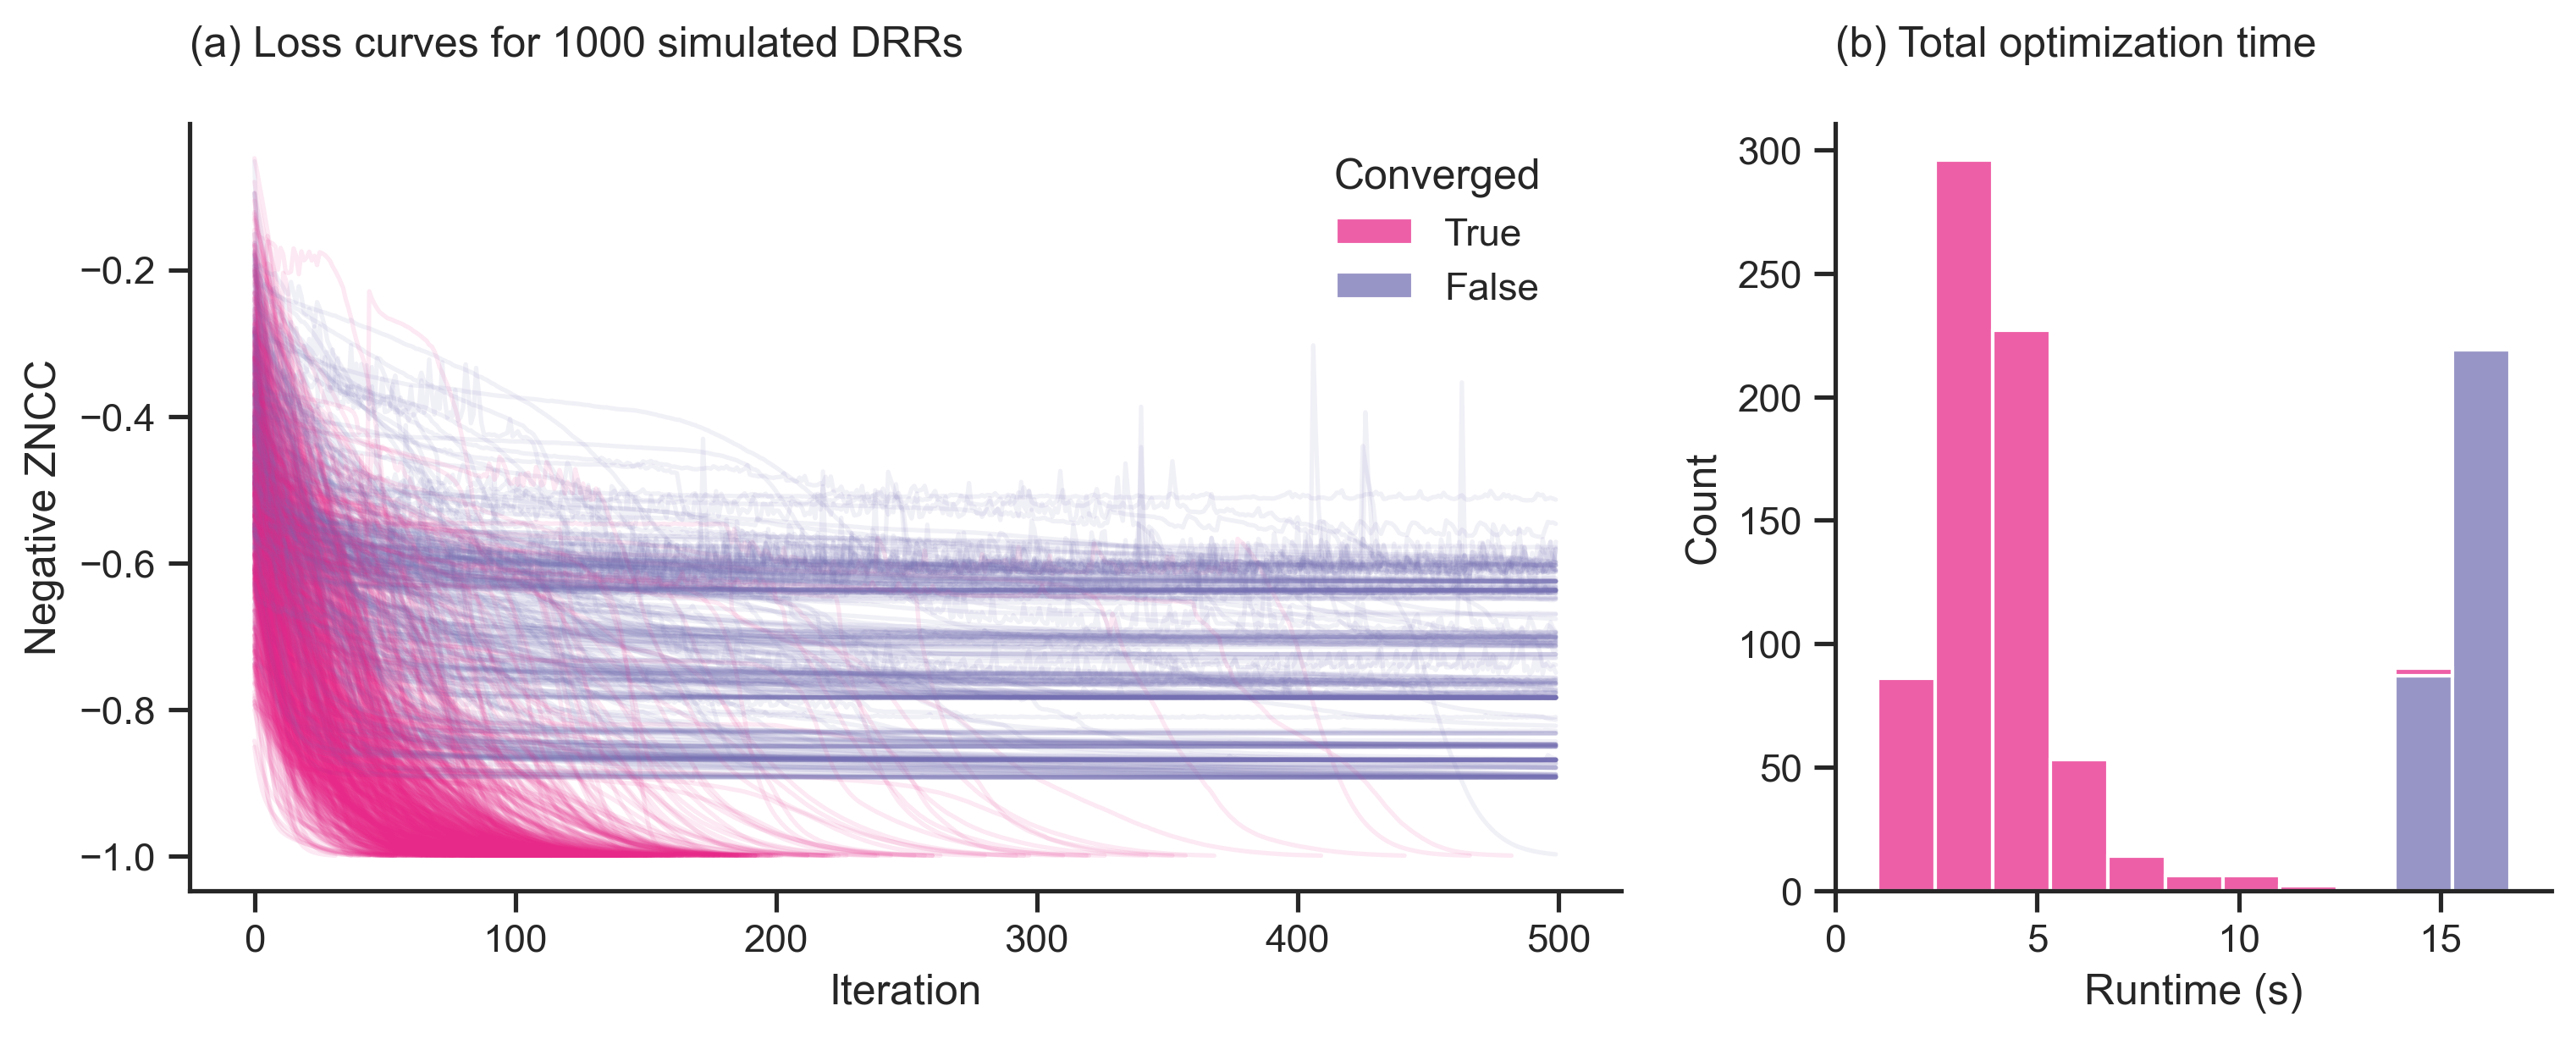

In [4]:
fig = plt.figure(dpi=300, figsize=plt.figaspect(1/3))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1], figure=fig)
ax_plot = plt.subplot(gs[0])
ax_hist = plt.subplot(gs[1])

# Plot the training trajectories
dfs = []
kwargs = {"alpha": 0.1, "lw": 1.25}
for file in Path("tmp").glob("*.csv"):
    df = pd.read_csv(file)
    df["runtime"] = df["time"].cumsum()
    df["converged"] = converged(df)
    color = colors[converged(df)]
    ax_plot.plot(df["itr"], df["loss"], color, **kwargs)
    dfs.append(df.iloc[-1])
ax_plot.set(xlabel="Iteration", ylabel="Negative ZNCC")
ax_plot.set_title(f"(a) Loss curves for {len(dfs)} simulated DRRs\n", loc="left")

# Plot the convergence timing histogram
df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
sns.histplot(data=df, x="runtime", hue="converged", hue_order=[True, False], multiple="stack", palette=colors, legend=True, ax=ax_hist)
sns.move_legend(ax_hist, loc="upper left", bbox_to_anchor=(-0.75, 1), title="Converged", frameon=False)
ax_hist.set(xlabel="Runtime (s)", xlim=(0, 17.75))
ax_hist.set_title("(b) Total optimization time\n", loc="left")

# Get optimization timing metrics
n_conv = df["converged"].astype(int).sum()
t_conv = df.query("converged == True")["runtime"].mean()
s_conv = df.query("converged == True")["runtime"].std()
nitr_conv = df.query("converged == True")["itr"].mean()
sitr_conv = df.query("converged == True")["itr"].std()
print(f"""{n_conv}/{len(df)} runs achieved convergence in {t_conv:.2f}±{s_conv:.2f}s ({nitr_conv:.2f}±{sitr_conv:.2f} iterations) on average""")

# Save the final figure!
# ax_hist.axvline(t_conv, ymax=0.975, color="k", ls="--")
plt.savefig("../../figures/optimization.pdf", bbox_inches="tight")
plt.show()

## Animations

Trying to animate the optimization loop.

In [5]:
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation
from tqdm import tqdm

In [6]:
# Utility functions for animating DRRs
volume, spacing = read_dicom("../../data/cxr")
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cpu")


def precompute_drrs(df, sdr, ax):
    imgs = []
    for _, row in tqdm(df.iterrows(), desc="Precomputing DRRs", total=len(df)):
        loss = row["loss"]
        params = row[["theta", "phi", "gamma", "bx", "by", "bz"]].values
        itr = drr(200, *params)
        img = plot_drr(itr, ticks=False, animated=True, ax=ax)
        # ax.set(title=f"-ZNCC={loss:.2f}")
        imgs.append([img])
    return imgs

Precomputing DRRs: 100%|███████████████████████████████████████████| 123/123 [00:38<00:00,  3.16it/s]


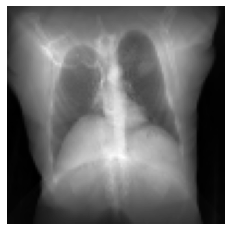

In [10]:
# csvfiles = Path("tmp").glob("*.csv")
# df = pd.read_csv(next(csvfiles))

fig, ax = plt.subplots()
imgs = precompute_drrs(df, sdr=200, ax=ax)
anim = ArtistAnimation(fig, imgs, interval=50, blit=True, repeat_delay=1000)
HTML(anim.to_jshtml())